In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
def savefile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp
from tqdm import tqdm
import os

In [2]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [3]:
print (final.shape)
final.head(5)

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [4]:


final["Time"] = pd.to_datetime(final["Time"] , unit = "s")
reviews_timesorted = final.sort_values(by = "Time")
print (reviews_timesorted.shape)
reviews_timesorted_score = reviews_timesorted["Score"]
print (reviews_timesorted_score.shape)
reviews_timesorted.head(5)

(364171, 12)
(364171,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [5]:

reviews_100k = reviews_timesorted.head(100000)
print (reviews_100k.shape)


reviews_100k_score = reviews_100k["Score"]
print (reviews_100k_score.shape)

reviews_100k.head()



(100000, 12)
(100000,)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:

pos_reviews = reviews_100k[reviews_100k["Score"] == 1]
print ("No of +ve reviews" , len(pos_reviews))
neg_reviews = reviews_100k[reviews_100k["Score"] == 0]
print ("No of -ve reviews" , len(neg_reviews))


No of +ve reviews 87729
No of -ve reviews 12271


In [7]:
from sklearn import model_selection

reviews_train, reviews_test, reviews_score_train , reviews_score_test = model_selection.train_test_split(reviews_100k, reviews_100k_score, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_test.shape)
print (reviews_score_test.shape)

(70000, 12)
(70000,)
(30000, 12)
(30000,)


# BoW :

In [28]:
count_vect = CountVectorizer() #in scikit-learn
reviews_train_bow = count_vect.fit_transform(reviews_train['CleanedText'].values)
# reviews_cv_bow = count_vect.transform(reviews_cv['CleanedText'].values)
reviews_test_bow = count_vect.transform(reviews_test['CleanedText'].values)

print("the type of count vectorizer ",type(reviews_train_bow))
print (reviews_train_bow.shape)
# print (reviews_cv_bow.shape)
print (reviews_test_bow.shape)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 31572)
(30000, 31572)


In [29]:
#This scaler can also be applied to sparse CSR or CSC matrices by passing 
#with_mean=False to avoid breaking the sparsity structure of the data.

from sklearn.preprocessing import StandardScaler

reviews_std_train_bow = StandardScaler(with_mean = False).fit_transform(reviews_train_bow)
reviews_std_test_bow = StandardScaler(with_mean = False).fit_transform(reviews_test_bow)

print (reviews_std_train_bow.shape)
print (reviews_std_test_bow.shape)

(70000, 31572)
(30000, 31572)


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
# tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} , { 'penalty' : ['l1' , 'l2'] }]
clf = LogisticRegression(class_weight = 'balanced' )
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 ,n_jobs=-1)
model.fit(reviews_std_train_bow, reviews_score_train)
savefile(model,"GridSearch_BoW_Logistic_Regression")
print(model.best_estimator_)
print(model.score(reviews_train_bow, reviews_score_train))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 122.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 140.6min finished


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.8953328332898942


0.500 (+/-0.000) for {'C': 0.0001, 'penalty': 'l1'}
0.924 (+/-0.004) for {'C': 0.0001, 'penalty': 'l2'}
0.930 (+/-0.004) for {'C': 0.01, 'penalty': 'l1'}
0.879 (+/-0.009) for {'C': 0.01, 'penalty': 'l2'}
0.840 (+/-0.014) for {'C': 1, 'penalty': 'l1'}
0.816 (+/-0.015) for {'C': 1, 'penalty': 'l2'}
0.805 (+/-0.013) for {'C': 100, 'penalty': 'l1'}
0.802 (+/-0.015) for {'C': 100, 'penalty': 'l2'}
0.802 (+/-0.013) for {'C': 10000, 'penalty': 'l1'}
0.798 (+/-0.017) for {'C': 10000, 'penalty': 'l2'}


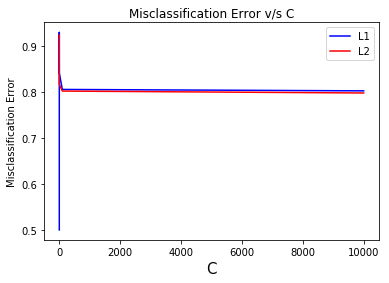

In [28]:
gsv = openfile("GridSearch_BoW_Logistic_Regression")

gsv.cv_results_

x1 = []
y1 = []
x2 = []
y2 = []

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 0.01 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (0.01, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 0.010000 is 92.481429%
4505


[[ 8040   566]
 [ 2960 58434]]


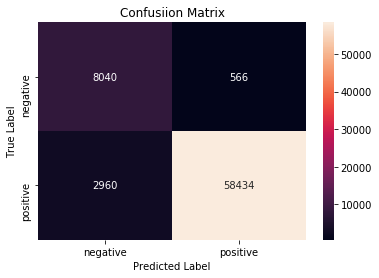

In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      8606
           1       0.99      0.95      0.97     61394

   micro avg       0.95      0.95      0.95     70000
   macro avg       0.86      0.94      0.90     70000
weighted avg       0.96      0.95      0.95     70000



### Feature-Extraction :

In [29]:
log_prob_reviews = model.coef_
bow_features = count_vect.get_feature_names()

print (log_prob_reviews.shape)
print (len(bow_features))


(1, 31572)
31572


In [30]:
feature_prob = pd.DataFrame(log_prob_reviews, columns = bow_features)
feature_prob_transpose = feature_prob.T
print (feature_prob_transpose.shape)




(31572, 1)


In [32]:
print("\n\n  25 Positive Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:25])
neg_prob = feature_prob_transpose[feature_prob_transpose[0] < 0]
print("\n\n  25 Negative Features:-\n",neg_prob[0].sort_values(ascending = True )[0:25])




  25 Positive Features:-
 great      0.195041
love       0.150351
best       0.145029
delici     0.115989
good       0.094601
excel      0.094002
perfect    0.093896
favorit    0.085513
nice       0.079817
wonder     0.075264
find       0.071845
tasti      0.068664
easi       0.068468
thank      0.064608
amaz       0.059321
keep       0.058510
alway      0.057533
high       0.056456
yummi      0.056208
addict     0.055264
awesom     0.054811
make       0.054662
happi      0.054542
snack      0.053879
enjoy      0.052018
Name: 0, dtype: float64


  25 Negative Features:-
 disappoint   -0.153719
worst        -0.103367
terribl      -0.094337
horribl      -0.083549
bad          -0.078929
return       -0.078390
money        -0.078067
aw           -0.077202
thought      -0.074718
unfortun     -0.071501
would        -0.071446
stale        -0.070457
bland        -0.068163
wast         -0.067319
threw        -0.065734
weak         -0.063315
didnt        -0.057026
mayb         -0.056424
sorri 

## Perturbation Test :

In [136]:
from scipy.sparse import find
from scipy.sparse import csr_matrix

reviews_std_train_bow_collinear = reviews_std_train_bow

epsilon = np.random.normal(loc=0.0, scale=0.001, size=(find(reviews_std_train_bow_collinear)[0].size)) 
# epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(reviews_std_train_bow_collinear)[0].size,))

index_0 , index_1 , index_2 = find(reviews_std_train_bow_collinear)
reviews_std_train_bow_collinear[index_0,index_1] = epsilon + reviews_std_train_bow_collinear[index_0,index_1]

In [137]:

model = LogisticRegression(C = 0.0001 , penalty= 'l2' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow_collinear , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow_collinear)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1.0, acc))

weight_dash = model.coef_
print (np.count_nonzero(weight_dash))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 1.000000 is 94.961429%
31572


In [138]:

weights_diff = (abs(weight - weight_dash)/weight) * 100


In [139]:
print(weights_diff[np.where(weights_diff > 10)].size)

13


There are 13 features passes 10% threshold and hence they are collinear

### Testing Sparsity :

In [85]:
model = LogisticRegression(C = 1000.0 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error_1000 = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (1000.0, error_1000*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1000.0, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 1000.000000 is 2.060000%

The accuracy of the Logistic Regression for C = 1000.000000 is 97.940000%

 Non-Zero weights  20529


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [86]:
model = LogisticRegression(C = 100.0 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error_100 = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (100.0, error_100*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (100.0, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 100.000000 is 2.085714%

The accuracy of the Logistic Regression for C = 100.000000 is 97.914286%

 Non-Zero weights  17630


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [87]:
model = LogisticRegression(C = 10.0 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error_10 = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (10.0, error_10*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (10.0, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 10.000000 is 2.068571%

The accuracy of the Logistic Regression for C = 10.000000 is 97.931429%

 Non-Zero weights  15981


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [93]:
model = LogisticRegression(C = 1.0 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error_1 = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (1.0, error_1*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1.0, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 1.000000 is 2.164286%

The accuracy of the Logistic Regression for C = 1.000000 is 97.835714%

 Non-Zero weights  12661


In [94]:
model = LogisticRegression(C = 0.1 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (0.1, error*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (0.1, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 0.100000 is 3.074286%

The accuracy of the Logistic Regression for C = 0.100000 is 96.925714%

 Non-Zero weights  10802


In [102]:
model = LogisticRegression(C = 0.01 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_bow , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error = 1 - acc
print ('\nThe error of the Logistic Regression for C = %f is %f%%' % (0.1, error*100))
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (0.1, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The error of the Logistic Regression for C = 0.100000 is 7.520000%

The accuracy of the Logistic Regression for C = 0.100000 is 92.480000%

 Non-Zero weights  4503


###  Randomized Search CV :

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
clf = LogisticRegression(class_weight = 'balanced' )

#Using GridSearchCV
model = RandomizedSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-1)
model.fit(reviews_std_train_bow, reviews_score_train)
savefile(model,"RandomSearch_BoW_Logistic_Regression_roc_auc_score")

print(model.best_estimator_)
print(model.score(reviews_train_bow, reviews_score_train))  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 131.8min finished


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.8953326118486108


0.500 (+/-0.000) for {'penalty': 'l1', 'C': 0.0001}
0.924 (+/-0.004) for {'penalty': 'l2', 'C': 0.0001}
0.930 (+/-0.004) for {'penalty': 'l1', 'C': 0.01}
0.879 (+/-0.009) for {'penalty': 'l2', 'C': 0.01}
0.840 (+/-0.014) for {'penalty': 'l1', 'C': 1}
0.816 (+/-0.015) for {'penalty': 'l2', 'C': 1}
0.805 (+/-0.008) for {'penalty': 'l1', 'C': 100}
0.802 (+/-0.015) for {'penalty': 'l2', 'C': 100}
0.798 (+/-0.011) for {'penalty': 'l1', 'C': 10000}
0.798 (+/-0.017) for {'penalty': 'l2', 'C': 10000}


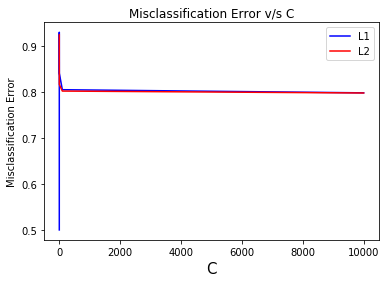

In [34]:
gsv = openfile("RandomSearch_BoW_Logistic_Regression_roc_auc_score")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_
means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [12]:
rsv = openfile('RandomSearch_BoW_Logistic_Regression_roc_auc_score')
print (rsv.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [14]:
model = LogisticRegression(C = 0.01 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_test_bow , reviews_score_test)

# predict the response
pred = model.predict(reviews_std_test_bow)

# evaluate accuracy
acc = accuracy_score(reviews_score_test, pred)
error = 1 - acc

print('\nThe Test accuracy of the Logistic Regression for C = %f is %f%%' % (0.01, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))


The Test accuracy of the Logistic Regression for C = 0.010000 is 91.700000%

 Non-Zero weights  1616


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[[ 3378   287]
 [ 2203 24132]]


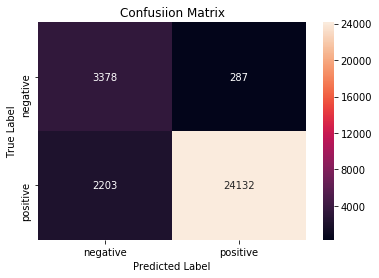

In [15]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test, pred))

              precision    recall  f1-score   support

           0       0.61      0.92      0.73      3665
           1       0.99      0.92      0.95     26335

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.80      0.92      0.84     30000
weighted avg       0.94      0.92      0.92     30000



# Tf-idf

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
reviews_train_tfidf = tf_idf_vect.fit_transform(reviews_train['CleanedText'].values)

reviews_test_tfidf = tf_idf_vect.transform(reviews_test['CleanedText'].values)

In [31]:
from sklearn.preprocessing import StandardScaler

reviews_std_train_tfidf = StandardScaler(with_mean = False).fit_transform(reviews_train_tfidf)
reviews_std_test_tfidf = StandardScaler(with_mean = False).fit_transform(reviews_test_tfidf)

print (reviews_std_train_tfidf.shape)
print (reviews_std_test_tfidf.shape)

(70000, 932590)
(30000, 932590)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
# tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} , { 'penalty' : ['l1' , 'l2'] }]
clf = LogisticRegression(class_weight = 'balanced' )
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 ,n_jobs=-1)
model.fit(reviews_std_train_tfidf, reviews_score_train)
savefile(model,"GridSearch_tfidf_Logistic_Regression")
print(model.best_estimator_)
print(model.score(reviews_train_tfidf, reviews_score_train))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9312697991692598


0.500 (+/-0.000) for {'C': 0.0001, 'penalty': 'l1'}
0.888 (+/-0.007) for {'C': 0.0001, 'penalty': 'l2'}
0.932 (+/-0.006) for {'C': 0.01, 'penalty': 'l1'}
0.884 (+/-0.007) for {'C': 0.01, 'penalty': 'l2'}
0.932 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
0.882 (+/-0.007) for {'C': 1, 'penalty': 'l2'}
0.929 (+/-0.004) for {'C': 100, 'penalty': 'l1'}
0.880 (+/-0.007) for {'C': 100, 'penalty': 'l2'}
0.870 (+/-0.015) for {'C': 10000, 'penalty': 'l1'}
0.880 (+/-0.007) for {'C': 10000, 'penalty': 'l2'}


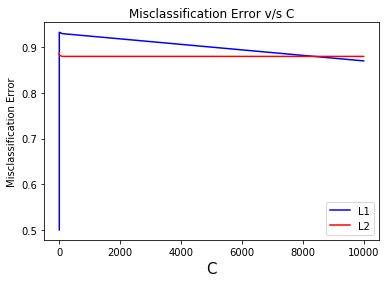

In [33]:
gsv = openfile("GridSearch_tfidf_Logistic_Regression")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} , { 'penalty' : ['l1' , 'l2'] }]
clf = LogisticRegression(class_weight = 'balanced' , n_jobs = -1)

#Using GridSearchCV
model1 = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=5 , verbose=1)
model1.fit(reviews_std_train_tfidf, reviews_score_train)
savefile(model1,"GridSearch_tfidf_Logistic_Regression_f1_score")
print(model1.best_estimator_)
print(model1.score(reviews_train_tfidf, reviews_score_train))    
# weight = model.coef_
    
 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 1 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_tfidf , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 1.000000 is 99.998571%
55278


[[ 8606     0]
 [    1 61393]]


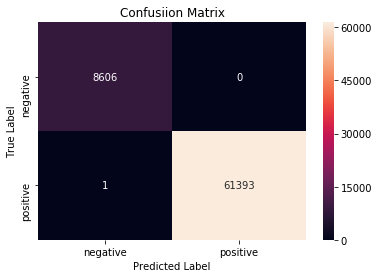

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [38]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8606
           1       1.00      1.00      1.00     61394

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000



### Feature Extraction :

In [45]:
log_prob_reviews = model.coef_
tfidf_features = tf_idf_vect.get_feature_names()

print (log_prob_reviews.shape)
print (len(tfidf_features))


(1, 932590)
932590


In [46]:
feature_prob = pd.DataFrame(log_prob_reviews, columns = tfidf_features)
feature_prob_transpose = feature_prob.T
print (feature_prob_transpose.shape)



(932590, 1)


In [48]:
print("\n\n  25 Positive Features:-\n",feature_prob_transpose[0].sort_values(ascending = False)[0:25])
neg_prob = feature_prob_transpose[feature_prob_transpose[0] < 0]
print("\n\n  25 Negative Features:-\n",neg_prob[0].sort_values(ascending = True )[0:25])




  25 Positive Features:-
 great              1.426797
love               1.082677
best               1.003508
delici             0.811017
good               0.767468
excel              0.677390
perfect            0.589614
favorit            0.500192
nice               0.479507
wonder             0.453446
find               0.427863
tasti              0.390960
high recommend     0.382519
use                0.369808
amaz               0.351143
enjoy              0.336660
yummi              0.323467
thank              0.318649
make               0.297289
keep               0.293000
littl              0.291101
like               0.286507
alway              0.270395
help               0.260772
wont disappoint    0.251568
Name: 0, dtype: float64


  25 Negative Features:-
 disappoint    -0.643591
worst         -0.583556
terribl       -0.400947
wast money    -0.391403
return        -0.358118
horribl       -0.353592
aw            -0.346940
wont buy      -0.333425
threw         -0.314287
two 

In [49]:
model = LogisticRegression(C = 1 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_test_tfidf , reviews_score_test)

# predict the response
pred = model.predict(reviews_std_test_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_test, pred)
error = 1 - acc

print('\nThe Test accuracy of the Logistic Regression for C = %f is %f%%' % (1, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The Test accuracy of the Logistic Regression for C = 1.000000 is 100.000000%

 Non-Zero weights  13345


### Perbutation Test :

In [53]:
from scipy.sparse import find
from scipy.sparse import csr_matrix

reviews_std_train_tfidf_collinear = reviews_std_train_tfidf

epsilon = np.random.normal(loc=0.0, scale=0.001, size=(find(reviews_std_train_tfidf_collinear)[0].size)) 
# epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(reviews_std_train_bow_collinear)[0].size,))

index_0 , index_1 , index_2 = find(reviews_std_train_tfidf_collinear)
reviews_std_train_tfidf_collinear[index_0,index_1] = epsilon + reviews_std_train_tfidf_collinear[index_0,index_1]

In [54]:

model = LogisticRegression(C = 1 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_tfidf_collinear , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_tfidf_collinear)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1.0, acc))

weight_dash = model.coef_
print (np.count_nonzero(weight_dash))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 1.000000 is 99.998571%
58528


In [55]:

weights_diff = (abs(weight - weight_dash)/weight) * 100


In [56]:
print(weights_diff[np.where(weights_diff > 10)].size)

29865


There are 13 features passes 10% threshold and hence they are collinear

### RandomSearchCV :

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
clf = LogisticRegression(class_weight = 'balanced' )

#Using GridSearchCV
model = RandomizedSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-1)
model.fit(reviews_std_train_tfidf, reviews_score_train)
savefile(model,"RandomSearch_tfidf_Logistic_Regression_roc_score")

print(model.best_estimator_)
print(model.score(reviews_train_tfidf, reviews_score_train))  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9400218268048897


0.500 (+/-0.000) for {'penalty': 'l1', 'C': 0.0001}
0.888 (+/-0.007) for {'penalty': 'l2', 'C': 0.0001}
0.932 (+/-0.006) for {'penalty': 'l1', 'C': 0.01}
0.884 (+/-0.007) for {'penalty': 'l2', 'C': 0.01}
0.933 (+/-0.005) for {'penalty': 'l1', 'C': 1}
0.882 (+/-0.007) for {'penalty': 'l2', 'C': 1}
0.928 (+/-0.006) for {'penalty': 'l1', 'C': 100}
0.880 (+/-0.007) for {'penalty': 'l2', 'C': 100}
0.870 (+/-0.010) for {'penalty': 'l1', 'C': 10000}
0.880 (+/-0.007) for {'penalty': 'l2', 'C': 10000}


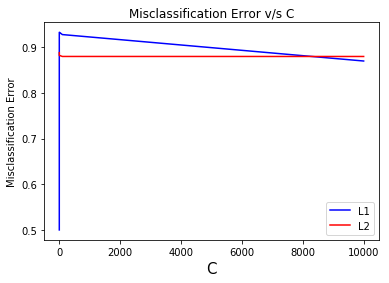

In [36]:
gsv = openfile("RandomSearch_tfidf_Logistic_Regression_roc_score")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [58]:
model = LogisticRegression(C = 0.01 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_train_tfidf , reviews_score_train)

# predict the response
pred = model.predict(reviews_std_train_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred)
error = 1 - acc

print('\nThe Train accuracy of the Logistic Regression for C = %f is %f%%' % (1, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The Train accuracy of the Logistic Regression for C = 1.000000 is 98.687143%

 Non-Zero weights  28464


[[ 8605     1]
 [  918 60476]]


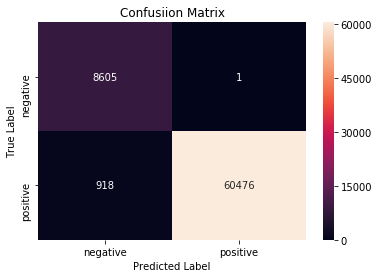

In [59]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [60]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8606
           1       1.00      0.99      0.99     61394

   micro avg       0.99      0.99      0.99     70000
   macro avg       0.95      0.99      0.97     70000
weighted avg       0.99      0.99      0.99     70000



In [61]:
model = LogisticRegression(C = 0.01 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_std_test_tfidf , reviews_score_test)

# predict the response
pred = model.predict(reviews_std_test_tfidf)

# evaluate accuracy
acc = accuracy_score(reviews_score_test, pred)
error = 1 - acc

print('\nThe Train accuracy of the Logistic Regression for C = %f is %f%%' % (1, acc*100))
print ("\n Non-Zero weights " , np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The Train accuracy of the Logistic Regression for C = 1.000000 is 97.850000%

 Non-Zero weights  6594


[[ 3665     0]
 [  645 25690]]


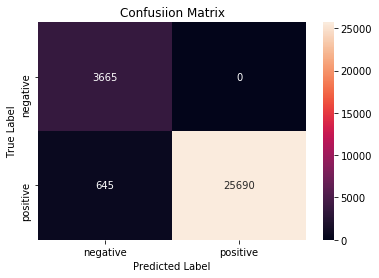

In [62]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test, pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3665
           1       1.00      0.98      0.99     26335

   micro avg       0.98      0.98      0.98     30000
   macro avg       0.93      0.99      0.95     30000
weighted avg       0.98      0.98      0.98     30000




# Word2Vec :

In [9]:
i=0
list_of_sent =[]
for sent in reviews_100k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [10]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=300, workers=4)

In [11]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12508
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


# AvgWord2Vec :

In [46]:
sent_vectors = [] #List to store all the avg w2vec's 

for sent in tqdm(reviews_100k['CleanedText']):
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
#     sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2v_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt 
    sent_vectors.append(sent_vec) 
sent_vectors = np.array(sent_vectors)
savefile(sent_vectors , 'AvgW2V_Logistic_Regression_2')

100%|██████████| 100000/100000 [00:14<00:00, 7055.07it/s]


In [37]:
sent_vectors = openfile('AvgW2V_Logistic_Regression_2')
# print (sent_vectors[0])
sent_vectors = np.array(sent_vectors)
print (reviews_100k_score.shape)
print (sent_vectors.shape)

(100000,)
(100000, 300)


In [38]:
# sent_vectors[0]

In [39]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
reviews_std_w2v = StandardScaler(with_mean = False).fit_transform(sent_vectors)
    
reviews_train_w2v, reviews_test_w2v, reviews_score_train_w2v , reviews_score_test_w2v = model_selection.train_test_split(reviews_std_w2v, reviews_100k_score, test_size=0.3, random_state=0)
print (reviews_train.shape)
print (reviews_score_train.shape)
print (reviews_test.shape)
print (reviews_score_test.shape)


(70000, 12)
(70000,)
(30000, 12)
(30000,)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
# tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} , { 'penalty' : ['l1' , 'l2'] }]
clf = LogisticRegression(class_weight = 'balanced' )
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
#Using GridSearchCV
model = GridSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 ,n_jobs=-1)
model.fit(reviews_train_w2v, reviews_score_train_w2v)
savefile(model,"GridSearch_w2v_Logistic_Regression")
print(model.best_estimator_)
print(model.score(reviews_train_w2v, reviews_score_train_w2v))    
# weight = model.coef_
    
 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 246.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 295.3min finished


LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9290953687875945


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.633 (+/-0.219) for {'C': 0.0001, 'penalty': 'l1'}
0.912 (+/-0.003) for {'C': 0.0001, 'penalty': 'l2'}
0.918 (+/-0.002) for {'C': 0.01, 'penalty': 'l1'}
0.921 (+/-0.002) for {'C': 0.01, 'penalty': 'l2'}
0.923 (+/-0.002) for {'C': 1, 'penalty': 'l1'}
0.923 (+/-0.002) for {'C': 1, 'penalty': 'l2'}
0.923 (+/-0.002) for {'C': 100, 'penalty': 'l1'}
0.923 (+/-0.002) for {'C': 100, 'penalty': 'l2'}
0.924 (+/-0.002) for {'C': 10000, 'penalty': 'l1'}
0.923 (+/-0.002) for {'C': 10000, 'penalty': 'l2'}


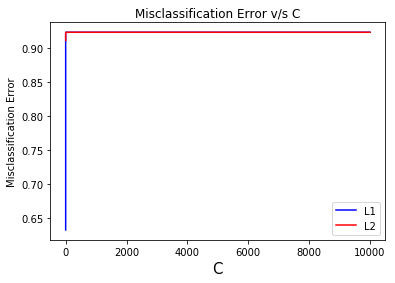

In [9]:
gsv = openfile("GridSearch_w2v_Logistic_Regression")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 10000 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_train_w2v , reviews_score_train_w2v)

# predict the response
pred = model.predict(reviews_train_w2v)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (10000, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 10000.000000 is 85.001429%
300


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 7463  1143]
 [ 9356 52038]]


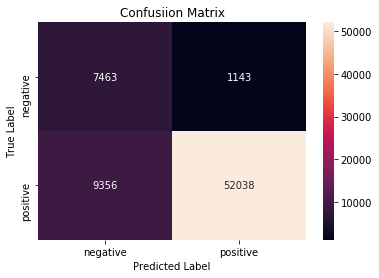

In [14]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train_w2v, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train_w2v, pred))

              precision    recall  f1-score   support

           0       0.44      0.87      0.59      8606
           1       0.98      0.85      0.91     61394

   micro avg       0.85      0.85      0.85     70000
   macro avg       0.71      0.86      0.75     70000
weighted avg       0.91      0.85      0.87     70000



In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 10000, penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_test_w2v , reviews_score_test_w2v)

# predict the response
pred = model.predict(reviews_test_w2v)

# evaluate accuracy
acc = accuracy_score(reviews_score_test_w2v, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (5, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 5.000000 is 84.950000%
300


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 3186   479]
 [ 4036 22299]]


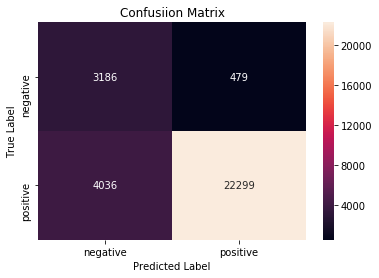

In [17]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test_w2v, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test_w2v, pred))

              precision    recall  f1-score   support

           0       0.44      0.87      0.59      3665
           1       0.98      0.85      0.91     26335

   micro avg       0.85      0.85      0.85     30000
   macro avg       0.71      0.86      0.75     30000
weighted avg       0.91      0.85      0.87     30000



### RandomSearchCV :

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
clf = LogisticRegression(class_weight = 'balanced' )

#Using GridSearchCV
model = RandomizedSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-1)
model.fit(reviews_train_w2v, reviews_score_train_w2v)
savefile(model,"RandomSearch_w2v_Logistic_Regression_roc_auc_score")

print(model.best_estimator_)
print(model.score(reviews_train_w2v, reviews_score_train_w2v))  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 231.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 259.2min finished


LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.929097662692173


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.633 (+/-0.219) for {'penalty': 'l1', 'C': 0.0001}
0.912 (+/-0.003) for {'penalty': 'l2', 'C': 0.0001}
0.918 (+/-0.002) for {'penalty': 'l1', 'C': 0.01}
0.921 (+/-0.002) for {'penalty': 'l2', 'C': 0.01}
0.923 (+/-0.002) for {'penalty': 'l1', 'C': 1}
0.923 (+/-0.002) for {'penalty': 'l2', 'C': 1}
0.923 (+/-0.002) for {'penalty': 'l1', 'C': 100}
0.923 (+/-0.002) for {'penalty': 'l2', 'C': 100}
0.923 (+/-0.002) for {'penalty': 'l1', 'C': 10000}
0.923 (+/-0.002) for {'penalty': 'l2', 'C': 10000}


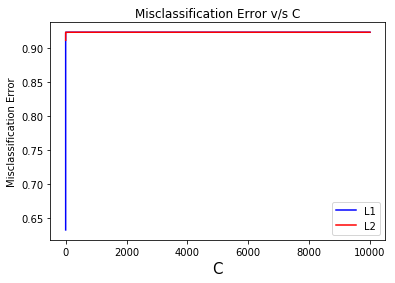

In [19]:
gsv = openfile("RandomSearch_w2v_Logistic_Regression_roc_auc_score")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 1000 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_train_w2v , reviews_score_train_w2v)

# predict the response
pred = model.predict(reviews_train_w2v)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (1000, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 1000.000000 is 85.004286%
300


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 10000, penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(reviews_test_w2v , reviews_score_test_w2v)

# predict the response
pred = model.predict(reviews_test_w2v)

# evaluate accuracy
acc = accuracy_score(reviews_score_test_w2v, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (5, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 5.000000 is 84.966667%
300


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 3189   476]
 [ 4034 22301]]


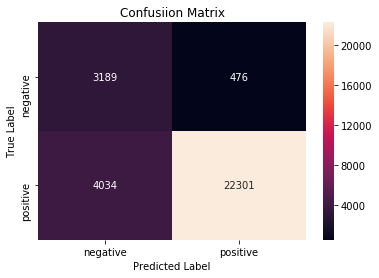

In [41]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_test_w2v, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_test_w2v, pred))

              precision    recall  f1-score   support

           0       0.44      0.87      0.59      3665
           1       0.98      0.85      0.91     26335

   micro avg       0.85      0.85      0.85     30000
   macro avg       0.71      0.86      0.75     30000
weighted avg       0.91      0.85      0.87     30000



# TF-IDF W2V :

In [12]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(reviews_train['CleanedText'].values)
# print (reviews_train.shape)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# print (dictionary)

In [13]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(reviews_train['CleanedText'].values): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
# print (tfidf_sent_vectors)
print (type(tfidf_sent_vectors))

100%|██████████| 70000/70000 [01:40<00:00, 699.81it/s]

<class 'list'>


In [16]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
print (tfidf_sent_vectors.shape)
# print (tfidf_sent_vectors[0])

(70000, 300)


In [17]:
savefile(tfidf_sent_vectors , 'tfidf_W2V_Logistic_Regression_2')

In [19]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
tfidf_sent_vectors = gsv = openfile("tfidf_W2V_Logistic_Regression_2")

tfidfw2v_vecs_norm =  StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)

#Not shuffling the data as we want it on time basis


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 

gsv = GridSearchCV(clf,param_grid,cv=5,verbose=1,n_jobs = -1)
gsv.fit(tfidfw2v_vecs_norm,reviews_score_train)
savefile(gsv,"GridSearch_tfidf_w2v_logistic_regression")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 265.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 354.7min finished


Best HyperParameter:  {'C': 50, 'penalty': 'l2'}
Best Accuracy: 90.94%


0.909 (+/-0.006) for {'C': 1000, 'penalty': 'l1'}
0.909 (+/-0.005) for {'C': 1000, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 500, 'penalty': 'l1'}
0.909 (+/-0.005) for {'C': 500, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 100, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 100, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 50, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 50, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 10, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 10, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 5, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 5, 'penalty': 'l2'}
0.909 (+/-0.006) for {'C': 1, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 1, 'penalty': 'l2'}
0.909 (+/-0.005) for {'C': 0.5, 'penalty': 'l1'}
0.909 (+/-0.006) for {'C': 0.5, 'penalty': 'l2'}
0.907 (+/-0.005) for {'C': 0.1, 'penalty': 'l1'}
0.908 (+/-0.005) for {'C': 0.1, 'penalty': 'l2'}
0.906 (+/-0.006) for {'C': 0.05, 'penalty': 'l1'}
0.908 (+/-0.005) for {'C': 0.05, 'penalty': 'l2'}
0.903 (+/-0.006) for {'C': 0

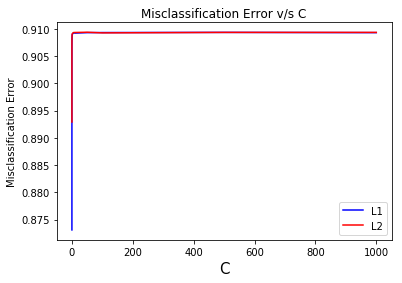

In [23]:
gsv = openfile("GridSearch_tfidf_w2v_logistic_regression")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 50 , penalty= 'l2' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(tfidfw2v_vecs_norm,reviews_score_train)

# predict the response
pred = model.predict(tfidfw2v_vecs_norm)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (50, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 50.000000 is 82.828571%
300


[[ 7263  1343]
 [10677 50717]]


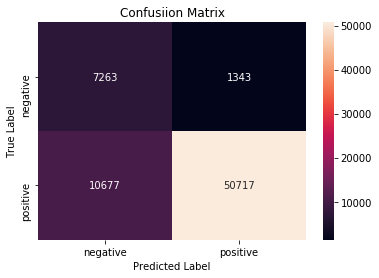

In [25]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.40      0.84      0.55      8606
           1       0.97      0.83      0.89     61394

   micro avg       0.83      0.83      0.83     70000
   macro avg       0.69      0.84      0.72     70000
weighted avg       0.90      0.83      0.85     70000



In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV , TimeSeriesSplit
from sklearn.model_selection import cross_val_score
    
    
param_grid = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4] , 'penalty' : ['l1' , 'l2'] }
clf = LogisticRegression(class_weight = 'balanced' )

#Using GridSearchCV
model = RandomizedSearchCV(clf, param_grid, scoring = 'roc_auc', cv=5 , verbose=1 , n_jobs=-1)
model.fit(tfidfw2v_vecs_norm, reviews_score_train)
savefile(model,"RandomSearch_tfidf_w2v_Logistic_Regression_roc_score")

print(model.best_estimator_)
# print(model.score(reviews_train_tfidf, reviews_score_train))  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 265.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 301.5min finished


LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
model = openfile('RandomSearch_tfidf_w2v_Logistic_Regression_roc_score')
model.best_score_

0.9048995114931067

0.500 (+/-0.000) for {'penalty': 'l1', 'C': 0.0001}
0.889 (+/-0.004) for {'penalty': 'l2', 'C': 0.0001}
0.897 (+/-0.003) for {'penalty': 'l1', 'C': 0.01}
0.901 (+/-0.002) for {'penalty': 'l2', 'C': 0.01}
0.905 (+/-0.003) for {'penalty': 'l1', 'C': 1}
0.905 (+/-0.003) for {'penalty': 'l2', 'C': 1}
0.905 (+/-0.003) for {'penalty': 'l1', 'C': 100}
0.905 (+/-0.004) for {'penalty': 'l2', 'C': 100}
0.905 (+/-0.003) for {'penalty': 'l1', 'C': 10000}
0.905 (+/-0.004) for {'penalty': 'l2', 'C': 10000}


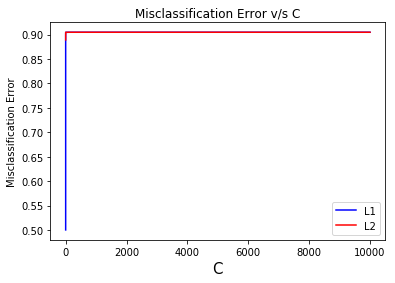

In [22]:
gsv = openfile("RandomSearch_tfidf_w2v_Logistic_Regression_roc_score")
x1=[]
y1=[]
x2=[]
y2=[]
gsv.cv_results_

means = gsv.cv_results_['mean_test_score']
stds = gsv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    if params['penalty'] == 'l1':
        x1.append(params['C'])
        y1.append(mean)
    else:
        x2.append(params['C'])
        y2.append(mean)
        
# plt.xlim(-10,1010)
# plt.ylim(0.5,1)
plt.xlabel("C",fontsize=15)
plt.ylabel("Misclassification Error")
plt.title('Misclassification Error v/s C')
plt.plot(x1,y1,'b',label="L1")
plt.plot(x2,y2,'r',label="L2")
plt.legend()
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(C = 10000 , penalty= 'l1' , class_weight = 'balanced' , n_jobs = -1)

# fitting the model
model.fit(tfidfw2v_vecs_norm,reviews_score_train)

# predict the response
pred = model.predict(tfidfw2v_vecs_norm)

# evaluate accuracy
acc = accuracy_score(reviews_score_train, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (10000, acc))
weight = model.coef_
print (np.count_nonzero(model.coef_))

/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



The accuracy of the Logistic Regression for C = 10000.000000 is 82.825714%
300


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 7251  1355]
 [10674 50720]]


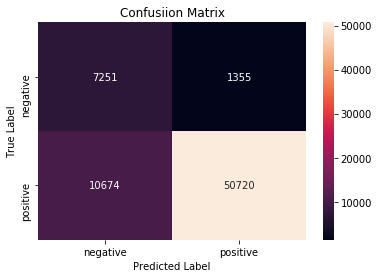

In [33]:
from sklearn.metrics import confusion_matrix
pred = model.predict(tfidfw2v_vecs_norm)
conf_matrix = confusion_matrix(reviews_score_train, pred)
print (conf_matrix)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
from sklearn.metrics import classification_report
print (classification_report(reviews_score_train, pred))

              precision    recall  f1-score   support

           0       0.40      0.84      0.55      8606
           1       0.97      0.83      0.89     61394

   micro avg       0.83      0.83      0.83     70000
   macro avg       0.69      0.83      0.72     70000
weighted avg       0.90      0.83      0.85     70000



# Conclusion :

- Features are multi-collinear . 
- Tf-idf perform well as compare to other featurization . 
- Sparsity increases when we decrease the value of C (inversely proportional to Lambda) with L1 Regularization

In [46]:
models = pd.DataFrame({'Model': ['Logistic Regression with Bow','Logistic Regression with Bow', "Logistic Regression with TFIDF" ,"Logistic Regression with TFIDF" , "Logistic Regression with AvgW2V" ,"Logistic Regression with AvgW2V" , " Logistic Regression with TFIDF-W2V" ,  " Logistic Regression with TFIDF-W2V"], 'CV': ["GridSearchCV","RandomSearchCV","GridSearchCV","RandomSearchCV","GridSearchCV","RandomSearchCV","GridSearchCV","RandomSearchCV"], 'C': [0.01,0.01,1,1,10000,10000,50,10000], 'Penalty': ['l1','l1','l1','l1','l1','l1','l2','l1'], 'AUC': [89,89,94,94,92,92,90,90], 'F1': [73,73,92,92,59,59,55,55] , 'Accuracy': [91,91,97.8,97.8,85,85,82,82]}, columns = ["Model", "CV", "C", "Penalty", "AUC",'F1','Accuracy'])
models

,Model,CV,C,Penalty,AUC,F1,Accuracy
0,Logistic Regression with Bow,GridSearchCV,0.01,l1,89,73,91.0
1,Logistic Regression with Bow,RandomSearchCV,0.01,l1,89,73,91.0
2,Logistic Regression with TFIDF,GridSearchCV,1.00,l1,94,92,97.8
3,Logistic Regression with TFIDF,RandomSearchCV,1.00,l1,94,92,97.8
4,Logistic Regression with AvgW2V,GridSearchCV,10000.00,l1,92,59,85.0
5,Logistic Regression with AvgW2V,RandomSearchCV,10000.00,l1,92,59,85.0
6,Logistic Regression with TFIDF-W2V,GridSearchCV,50.00,l2,90,55,82.0
7,Logistic Regression with TFIDF-W2V,RandomSearchCV,10000.00,l1,90,55,82.0
